In [1]:
%config IPCompleter.greedy=True

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import tensorflow as tf
import variational_autoencoder as vae

print("Tensor Flow version {}".format(tf.__version__))

D:\z_outsourced_programs\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Tensor Flow version 1.8.0


In [3]:
#test utils

def print_decoded_tensors_as_dict(weapon_data, array_of_tensors):
    genDict = {}
    
    for tensor in array_of_tensors:
        decoded = weapon_data.decode_processed_tensor(tensor)
        
        for key, value in decoded.items():
            if key not in genDict:
                genDict[key] = []
            genDict[key].append(value)
    
    for key, value in genDict.items():
            print(key, "=", value)

In [4]:
import weapon_data as weapons

network_architecture = \
    dict(n_input=0, #set it in with scope
         n_hidden_1=14,
         n_hidden_2=15,
         n_z=2)  

learning_rate = 0.01
optimizer =  tf.train.AdamOptimizer(learning_rate)
#optimizer = tf.train.RMSPropOptimizer(learning_rate)
transfer_fct = lambda x : tf.nn.tanh(x)
num_epochs = 10
batch_size = 1
epoch_debug_step = 1
    
with tf.Session() as sess:
    weapon_data = weapons.DataSet(seed=19071991) 
    network_architecture['n_input'] = weapon_data.num_features
  
    network = vae.get_new_trained(sess, weapon_data, network_architecture, optimizer, 
                              transfer_fct, batch_size, num_epochs, epoch_debug_step)


Epoch:0001, cost=23.046435601
Epoch:0002, cost=21.019927756
Epoch:0003, cost=20.441246265
Epoch:0004, cost=19.779068831
Epoch:0005, cost=19.641180000
Epoch:0006, cost=19.741274917
Epoch:0007, cost=19.105970721
Epoch:0008, cost=19.568770434
Epoch:0009, cost=17.014551250
Epoch:0010, cost=15.456455318
Trained model saved! You can find it in './trained_vae/model.ckpt'


In [5]:
with tf.Session(graph=tf.Graph()) as sess:
    network = vae.get_untrained(sess, network_architecture, optimizer, transfer_fct, batch_size)
    network = vae.restore(network, "trained_vae/model.ckpt")
        
    weapon_data = weapons.DataSet(seed=19071991) 
    samples = weapon_data.next_batch(batch_size)
    x_reconstructed = network.encode_and_decode(samples)
    
    print(samples)
    print(x_reconstructed)
    
    print_decoded_tensors_as_dict(weapon_data, np.concatenate((samples,x_reconstructed), axis=0))

INFO:tensorflow:Restoring parameters from trained_vae/model.ckpt
[[-0.70326645 -0.48674743 -0.30162464 -0.29826301 -0.22336265  1.3003496
  -0.75793673 -0.59816232  0.19378264 -1.11913753 -0.86609068 -0.28002455
   0.55030494  2.19514536  3.58362519  0.55859823 -0.28577464 -0.32322997
  -0.50421948 -0.54611868 -0.36023741 -0.52522573  2.45919073 -0.2672411 ]]
[[-1.2020228  -0.7937411  -0.31446782 -0.71914965  0.260878    1.4008116
  -0.614611   -0.8130327   0.995099   -0.89871156 -0.9356314   0.27635598
  -0.03830398  0.58076525  0.20245719  1.3864859   0.2282736  -0.08239971
  -0.35243344 -0.05339414  0.8216794  -0.56983817  0.9069236   0.1279099 ]]
damages_first = ['26.5', '14.154223090608234']
damages_last = ['20.0', '12.636953787952233']
dmg_distances_first = ['11.0', '10.809114953405938']
dmg_distances_last = ['50.0', '32.4487406140964']
drag = ['0.0024999999441206455', '0.0030859343854165115']
firemode_Automatic = ['1.0', '1.048547034469915']
firemode_Semi-Automatic = ['0.0', '0.

INFO:tensorflow:Restoring parameters from trained_vae/model.ckpt


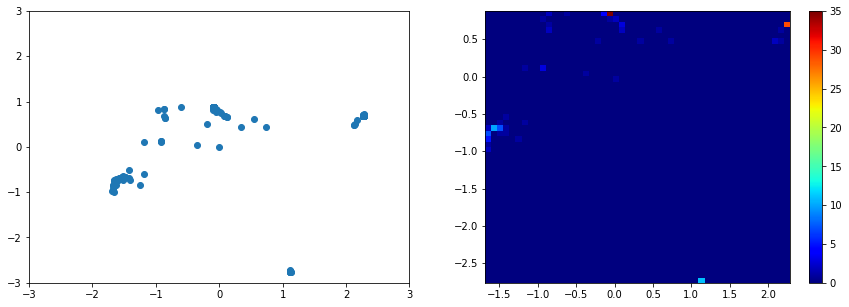

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

all_z = np.zeros((1,network_architecture['n_z']))
with tf.Session(graph=tf.Graph()) as sess:
    network = vae.get_untrained(sess, network_architecture, optimizer, transfer_fct, batch_size)
    network = vae.restore(network, "trained_vae/model.ckpt")
    
    weapon_data = weapons.DataSet(seed=19071991) 
    total_batch = int(weapon_data.num_examples / batch_size) 
    
    # Loop over all batches
    for i in range(total_batch):
        batch = weapon_data.next_batch(batch_size)
        z_mean = network.calculate_z_mean(batch)
        all_z = np.vstack((all_z, z_mean))

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(all_z[:,0], all_z[:,1])
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.subplot(1,2,2)
plt.hist2d(all_z[:,0], all_z[:,1], (50, 50), cmap=plt.cm.jet)
plt.colorbar()

In [7]:
# Testing
with tf.Session(graph=tf.Graph()) as sess:
    network = vae.get_untrained(sess, network_architecture, optimizer, transfer_fct, batch_size)
    network = vae.restore(network, "trained_vae/model.ckpt")
    
    generated = []
    for i in range(4):
        random_val = np.random.normal(size=(1,network_architecture["n_z"]))
        x_test = network.decode_from_latent_space(random_val)
        generated.append(x_test[0])
        
    weapon_data = weapons.DataSet(seed=19071991) 
    print_decoded_tensors_as_dict(weapon_data, generated)

INFO:tensorflow:Restoring parameters from trained_vae/model.ckpt
damages_first = ['80.15472925491693', '56.36197773405936', '24.848753363870294', '52.87579753111174']
damages_last = ['58.47196207483085', '41.85417563386442', '10.727825219839264', '29.34764786072265']
dmg_distances_first = ['10.910621468887744', '12.289474373587389', '20.052056502870357', '20.561660732216687']
dmg_distances_last = ['105.66235377513189', '80.25946254052447', '29.74742535653435', '61.15762279870653']
drag = ['0.0028130089073218636', '0.003954857648738474', '0.003288543642434613', '0.0023720569518609165']
firemode_Automatic = ['-0.027911365791978615', '0.1152164976480144', '0.311917513883339', '-0.027920928464676253']
firemode_Semi-Automatic = ['0.1443852482923157', '0.1980682572581001', '0.739172287200995', '0.7694706568375733']
hiprecoildec = ['3.8858855346017065', '4.196058031147216', '5.868531883997618', '4.634664488614292']
hiprecoilright = ['1.095489259185201', '1.0298377015147138', '0.49314315383992